In [9]:
include("../source/spin-1_XY_ED.jl")

odlro_matrix (generic function with 1 method)

### 1) Perturbative energy

In [13]:
N = 18
J1,J3,D,h = 1.0,0.1,0.1,1.0
boundary = "OBC"
use_sparse = false
n::Int64 = 3
mz::Int64 = (2*n-N)

@time begin
    nearest_bond_list = gen_bonds_1D(N,boundary)
    sec_nbr_bond_list = gen_2nd_nbr_bonds_1D(N,boundary)
    third_nbr_bond_list = gen_3rd_nbr_bonds_1D(N,boundary)
    basis_list = gen_basis_mz_1D_op(N,mz)
    println(length(basis_list))
#     basis_new1 = similar(basis_list[1])
#     basis_new2 = similar(basis_list[1])
#     scar_state::Vector{Float64} = scar_state_1D(N,n,basis_list)
#     scar_energy::Float64 = mz*h+N*D
#     H_XY,H_size = Ham_XY_1D(J1,J3,D,h,N,basis_list,basis_new1,basis_new2,nearest_bond_list,
#                             third_nbr_bond_list,use_sparse)  
#     H_sec_nbr,H_size1 = Ham_2nd_nbr_1D(N,basis_list,basis_new1,sec_nbr_bond_list,use_sparse)
end;

80580
  0.080538 seconds (873.82 k allocations: 175.152 MiB, 33.31% gc time)


In [15]:
@time XY_energy,XY_eigenvector = eigen(H_XY);

  0.001624 seconds (16 allocations: 223.891 KiB)


In [16]:
J2_list::Vector{Float64} = Vector{Float64}(LinRange(0.00,0.05,60))
# J2_list::Vector{Float64} = Vector{Float64}([0.02])
E_corr_list::Vector{Float64} = Vector{Float64}()
E1_list::Vector{Float64} = Vector{Float64}(undef,length(J2_list))
E2_list::Vector{Float64} = Vector{Float64}(undef,length(J2_list))
E3_list::Vector{Float64} = Vector{Float64}(undef,length(J2_list))
E4_list::Vector{Float64} = Vector{Float64}(undef,length(J2_list))
exact_energy_list::Vector{Float64} = Vector{Float64}(undef,length(J2_list))
scar_eigenspec_overlap_list::Vector{Float64} = Vector{Float64}(undef,H_size)
J2_scar_eigenspec_overlap_list::Vector{Float64} = Vector{Float64}(undef,H_size)

outvect_n::Vector{Float64} = Vector{Float64}(undef,H_size)
outvect_m::Vector{Float64} = similar(outvect_n)
outvect_k::Vector{Float64} = similar(outvect_n)
outvect_l::Vector{Float64} = similar(outvect_n)

order = "3"

@time begin    
    for (j,E) in enumerate(XY_energy)
        scar_eigenspec_overlap_list[j] = abs2(dot(XY_eigenvector[:,j],scar_state))
    end
    scar_overlap,scar_index = findmax(scar_eigenspec_overlap_list)
    E_corr_list = nondeg_pert_energy(H_sec_nbr,XY_energy,XY_eigenvector,scar_index,scar_state,
                                   scar_energy,outvect_n,outvect_m,outvect_k,order)
#     E_corr_4th = nondeg_4th_pert_energy(H_sec_nbr,XY_energy,XY_eigenvector,max_index,scar_state,
#                                    scar_energy,outvect_n,outvect_m,outvect_k,outvect_l)
    E_corr_1st::Float64 = E_corr_list[1]
    E_corr_2nd::Float64 = E_corr_list[2]
    E_corr_3rd::Float64 = E_corr_list[3]
#     println(scar_overlap," ",scar_index)
#     println("----")
    for (i,J2) in enumerate(J2_list)
        H_total = H_XY + J2*H_sec_nbr
        total_energy,total_eigenvector = eigen(H_total)

        for (j,E) in enumerate(total_energy)
            J2_scar_eigenspec_overlap_list[j] = abs2(dot(total_eigenvector[:,j],scar_state))
        end
        max_overlap,max_index = findmax(J2_scar_eigenspec_overlap_list)
        exact_energy_list[i] = total_energy[max_index]
#         println(max_overlap," ",max_index," ",total_energy[max_index])
        
        E1_list[i] = scar_energy+(J2*E_corr_1st)
        E2_list[i] = scar_energy+(J2*E_corr_1st)+((J2^2)*E_corr_2nd)
        E3_list[i] = scar_energy+(J2*E_corr_1st)+((J2^2)*E_corr_2nd)+((J2^3)*E_corr_3rd)
#         E4_list[i] = scar_energy+(J2*E_corr_1st)+((J2^2)*E_corr_2nd)+((J2^3)*E_corr_3rd)+
#                      ((J2^4)*E_corr_4th)
#         println(E_corr_1st," ",E_corr_2nd," ",E_corr_3rd)
    end
end;

pert_folder = "D:\\IACS_Project\\spin-1_XY\\data\\1D\\spin-1_XY_N=$(N)\\sec_nbr_perturbed\\$(boundary)\\perturbative_energy"
if !isdir(pert_folder)
    mkpath(pert_folder)
end

J2_max = J2_list[end]
pert_file = joinpath(pert_folder,"Sn=$(n)_J1=$(round(J1,digits=6))_J3=$(round(J3,digits=6))_D=$(round(D,digits=6))_h=$(round(h,digits=6))_J2max=$(round(J2_max,digits=6)).jld2")
# @save pert_file J2_values=J2_list ED_energy=exact_energy_list 1st_order=E1_list 2nd_order=E2_list 3rd_order=E3_list; 

  0.099677 seconds (80.77 k allocations: 32.728 MiB, 8.80% gc time)


"D:\\IACS_Project\\spin-1_XY\\data\\1D\\spin-1_XY_N=6\\sec_nbr_perturbed\\OBC\\perturbative_energy\\Sn=2_J1=1.0_J3=0.1_D=0.1_h=1.0_J2max=0.05.jld2"

#### I) Perturbative energy vs Exact energy

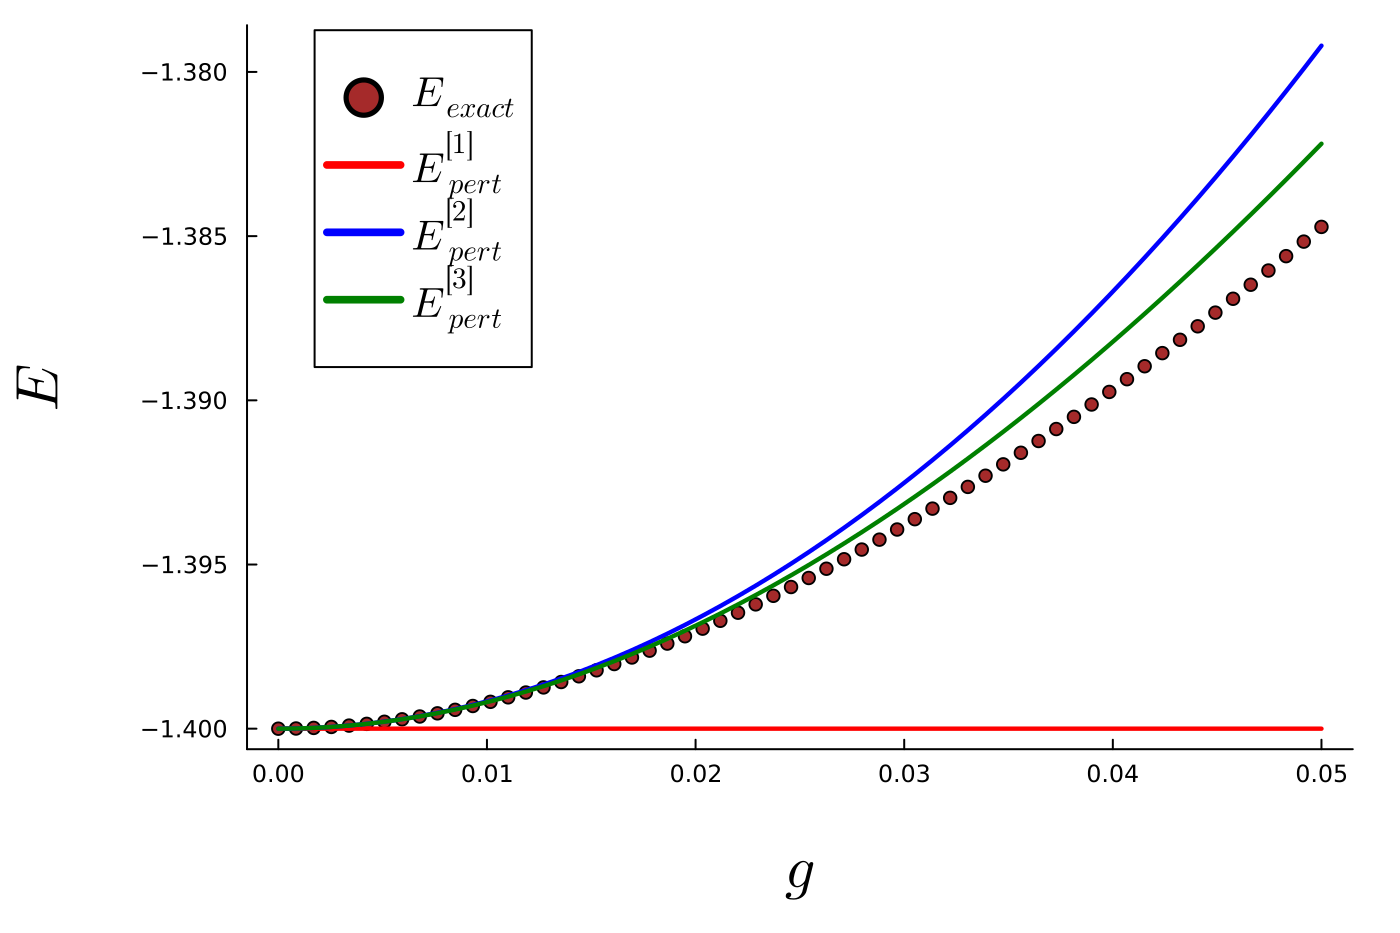

In [18]:
using Plots
using LaTeXStrings
using Plots.PlotMeasures
gr()

plot_size = (700,466.67)

p = scatter(J2_list,exact_energy_list,marker=:circle,markersize=3.5,markercolor=:brown,markerstrokecolor=:black,
         markerstrokewidth=1,label="\$E_{exact}\$",size=plot_size,dpi=200)

plot!(J2_list,E1_list,lw=2.2,c=:red,label="\$E^{[1]}_{pert}\$")
plot!(J2_list,E2_list,lw=2.2,c=:blue,label="\$E^{[2]}_{pert}\$")
plot!(J2_list,E3_list,lw=2.2,c=:green,label="\$E^{[3]}_{pert}\$")
# plot!(J2_list,E4_list,lw=2.2,c=:purple,label="\$E^{[4]}_{pert}\$")

plot!(left_margin=4mm,right_margin=4mm,top_margin=1.2mm,bottom_margin=5mm)
plot!(framestyle=:axis)
plot!(grid=false,gridlinewidth=0.6,gridalpha=0.2,gridcolor=:gray)
plot!(legend_position=(0.15,0.9),legendfontsize=14,legend_background_color=:white,
    legend_foreground_color=:black,legend_columns=1)
# plot!(ylims=(-3.45,-3.35))

xlabel!("\n\$g\$",guidefontsize=20)
ylabel!("\$E\$\n",guidefontsize=20)
title_text = "\$ N = $N \\quad $boundary,\\ J_{1} = $(round(J1,digits=6)),\\ J_{3} = $(round(J3,digits=6)), \\ D = $(round(D,digits=6)), \\ h = $(round(h,digits=6)) \$"
# title!(title_text,titlefontsize=16)

x1,x_step,x2 = 0.00,0.01,0.05
y1,y_step,y2 = 0.6,0.005,0.615
# y1,y_step,y2 = -1.4,0.005,-1.380
xticks = (x1:x_step:x2,[@sprintf("%.2f",x) for x in x1:x_step:x2])
yticks = (y1:y_step:y2,[@sprintf("%.3f",y) for y in y1:y_step:y2])
xminor_ticks = 2
yminor_ticks = 2
# plot!(xticks=xticks,yticks=yticks,xminorgrid=false,yminorgrid=false,
#       xminorticks=xminor_ticks, yminorticks=yminor_ticks,tickfontsize=15,tick_direction=:out)
# plot!(ylims=(-4.5,-2.5))

folder_name = "D:\\IACS_Project\\spin-1_XY\\plots\\1D\\spin-1_XY_N=$(N)\\sec_nbr_perturbed\\$(boundary)\\perturbative_energy"
if !isdir(folder_name)
    mkpath(folder_name)
end

J2 = round(J2_list[end],digits=6)
file_path = joinpath(folder_name,"Perturbative_energy_Sn=$(n)_J2max=$(J2)_J1=$(round(J1,digits=6))_J3=$(round(J3,digits=6))_D=$(round(D,digits=6))_h=$(round(h,digits=6)).png")

display(p)
# savefig(p,file_path)

#### II) Perturbative energy - Exact energy

In [ ]:
using Plots
using LaTeXStrings
using Plots.PlotMeasures
gr()

plot_size = (700,466.67)

p = plot(J2_list,E2_list-exact_energy_list,lw=2.2,c=:blue,label="\$E^{[2]}_{pert}\$",
         size=plot_size,dpi=200)
plot!(J2_list,E3_list-exact_energy_list,lw=2.2,c=:green,label="\$E^{[3]}_{pert}\$")

plot!(left_margin=4.5mm,right_margin=4mm,top_margin=1.2mm,bottom_margin=5mm)
plot!(framestyle=:axis)
plot!(grid=false,gridlinewidth=0.6,gridalpha=0.2,gridcolor=:gray)
plot!(legend_position=(0.15,0.85),legendfontsize=14,legend_background_color=:white,
    legend_foreground_color=:black,legend_columns=1)
# plot!(ylims=(-3.45,-3.35))

xlabel!("\n\$g\$",guidefontsize=20)
ylabel!("\$E_{pert}-E_{exact}\$\n",guidefontsize=20)
title_text = "\$ N = $N \\quad $boundary,\\ J_{1} = $(round(J1,digits=6)),\\ J_{3} = $(round(J3,digits=6)), \\ D = $(round(D,digits=6)), \\ h = $(round(h,digits=6)) \$"
# title!(title_text,titlefontsize=16)

x1,x_step,x2 = 0.00,0.01,0.05
y1,y_step,y2 = -0.001,0.001,0.002
xticks = (x1:x_step:x2,[@sprintf("%.2f",x) for x in x1:x_step:x2])
yticks = (y1:y_step:y2,[@sprintf("%.3f",y) for y in y1:y_step:y2])
xminor_ticks = 2
yminor_ticks = 2
plot!(xticks=xticks,yticks=yticks,xminorgrid=false,yminorgrid=false,
      xminorticks=xminor_ticks, yminorticks=yminor_ticks,tickfontsize=15,tick_direction=:out)
plot!(xlims=(J2_list[1]-0.0005,J2_list[end]+0.0005))

folder_name = "D:\\IACS_Project\\spin-1_XY\\plots\\1D\\spin-1_XY_N=$(N)\\sec_nbr_perturbed\\$(boundary)\\perturbative_energy"
if !isdir(folder_name)
    mkpath(folder_name)
end

J2 = round(J2_list[end],digits=6)
file_path = joinpath(folder_name,"Perturbative_energy_difference_Sn=$(n)_J2max=$(J2)_J1=$(round(J1,digits=6))_J3=$(round(J3,digits=6))_D=$(round(D,digits=6))_h=$(round(h,digits=6)).png")

display(p)
# savefig(p,file_path)

### 2) Perturbative wave function

In [32]:
N = 6
J1,J3,D,h = 1.0,0.1,0.1,1.0
boundary = "OBC"
use_sparse = false
n::Int64 = 3
mz::Int64 = 2*n-N

@time begin
    nearest_bond_list = gen_bonds_1D(N,boundary)
    sec_nbr_bond_list = gen_2nd_nbr_bonds_1D(N,boundary)
    third_nbr_bond_list = gen_3rd_nbr_bonds_1D(N,boundary)
    basis_list = gen_basis_mz_1D(N,mz)
    basis_new1 = similar(basis_list[1])
    basis_new2 = similar(basis_list[1])
    scar_state::Vector{Float64} = scar_state_1D(N,n,basis_list)
    scar_energy::Float64 = mz*h+N*D
    H_XY,H_size = Ham_XY_1D(J1,J3,D,h,N,basis_list,basis_new1,basis_new2,nearest_bond_list,
                            third_nbr_bond_list,use_sparse)  
    H_sec_nbr,H_size = Ham_2nd_nbr_1D(N,basis_list,basis_new1,sec_nbr_bond_list,use_sparse)
end;

  0.000872 seconds (6.19 k allocations: 761.312 KiB)


In [33]:
@time XY_energy,XY_eigenvector = eigen(H_XY);

  0.010618 seconds (16 allocations: 518.828 KiB)


In [34]:
J2_list::Vector{Float64} = Vector{Float64}(LinRange(0.00,0.05,60))
# J2_list::Vector{Float64} = Vector{Float64}([0.02])
pert_overlap_list::Vector{Float64} = Vector{Float64}()
J2_ED_overlap_list::Vector{Float64} = Vector{Float64}(undef,length(J2_list))
J2_pert_1st_overlap_list::Vector{Float64} = Vector{Float64}(undef,length(J2_list))
J2_pert_2nd_overlap_list::Vector{Float64} = Vector{Float64}(undef,length(J2_list))
scar_eigenspec_overlap_list::Vector{Float64} = Vector{Float64}(undef,H_size)
J2_scar_eigenspec_overlap_list::Vector{Float64} = Vector{Float64}(undef,H_size)

outvect_n::Vector{Float64} = Vector{Float64}(undef,H_size)
outvect_m::Vector{Float64} = similar(outvect_n)
outvect_k::Vector{Float64} = similar(outvect_n)

order = "2"

@time begin
    for (j,E) in enumerate(XY_energy)
        scar_eigenspec_overlap_list[j] = abs2(dot(XY_eigenvector[:,j],scar_state))
    end
    scar_overlap,scar_index = findmax(scar_eigenspec_overlap_list)
#     println(scar_overlap," ",scar_index)
#     println("----")
    for (i,J2) in enumerate(J2_list)
        H_total = H_XY + J2*H_sec_nbr
        total_energy,total_eigenvector = eigen(H_total)

        for (j,E) in enumerate(total_energy)
            J2_scar_eigenspec_overlap_list[j] = abs2(dot(total_eigenvector[:,j],scar_state))
        end
        max_overlap,max_index = findmax(J2_scar_eigenspec_overlap_list)
        J2_ED_overlap_list[i] = max_overlap
#         println(max_overlap," ",max_index," ",total_energy[max_index])

        pert_overlap_list = nondeg_pert_wf_overlap(J2,H_sec_nbr,XY_energy,XY_eigenvector,scar_index,
                                           scar_state,scar_energy,outvect_n,outvect_m,outvect_k,order)
        pert_1st_overlap = pert_overlap_list[1]
        pert_2nd_overlap = pert_overlap_list[2]
        J2_pert_1st_overlap_list[i] = pert_1st_overlap
        J2_pert_2nd_overlap_list[i] = pert_2nd_overlap
    end
end;

pert_folder = "D:\\IACS_Project\\spin-1_XY\\data\\1D\\spin-1_XY_N=$(N)\\sec_nbr_perturbed\\$(boundary)\\perturbative_wave_function"
if !isdir(pert_folder)
    mkpath(pert_folder)
end

J2_max = J2_list[end]
pert_file = joinpath(pert_folder,"Sn=$(n)_J1=$(round(J1,digits=6))_J3=$(round(J3,digits=6))_D=$(round(D,digits=6))_h=$(round(h,digits=6))_J2max=$(round(J2_max,digits=6)).jld2")
# @save pert_file J2_values=J2_list ED_fidelity=J2_ED_overlap_list 1st_order=J2_pert_1st_overlap_list 2nd_order=J2_pert_2nd_overlap_list; 

  4.368410 seconds (1.30 M allocations: 1.437 GiB, 0.31% gc time)


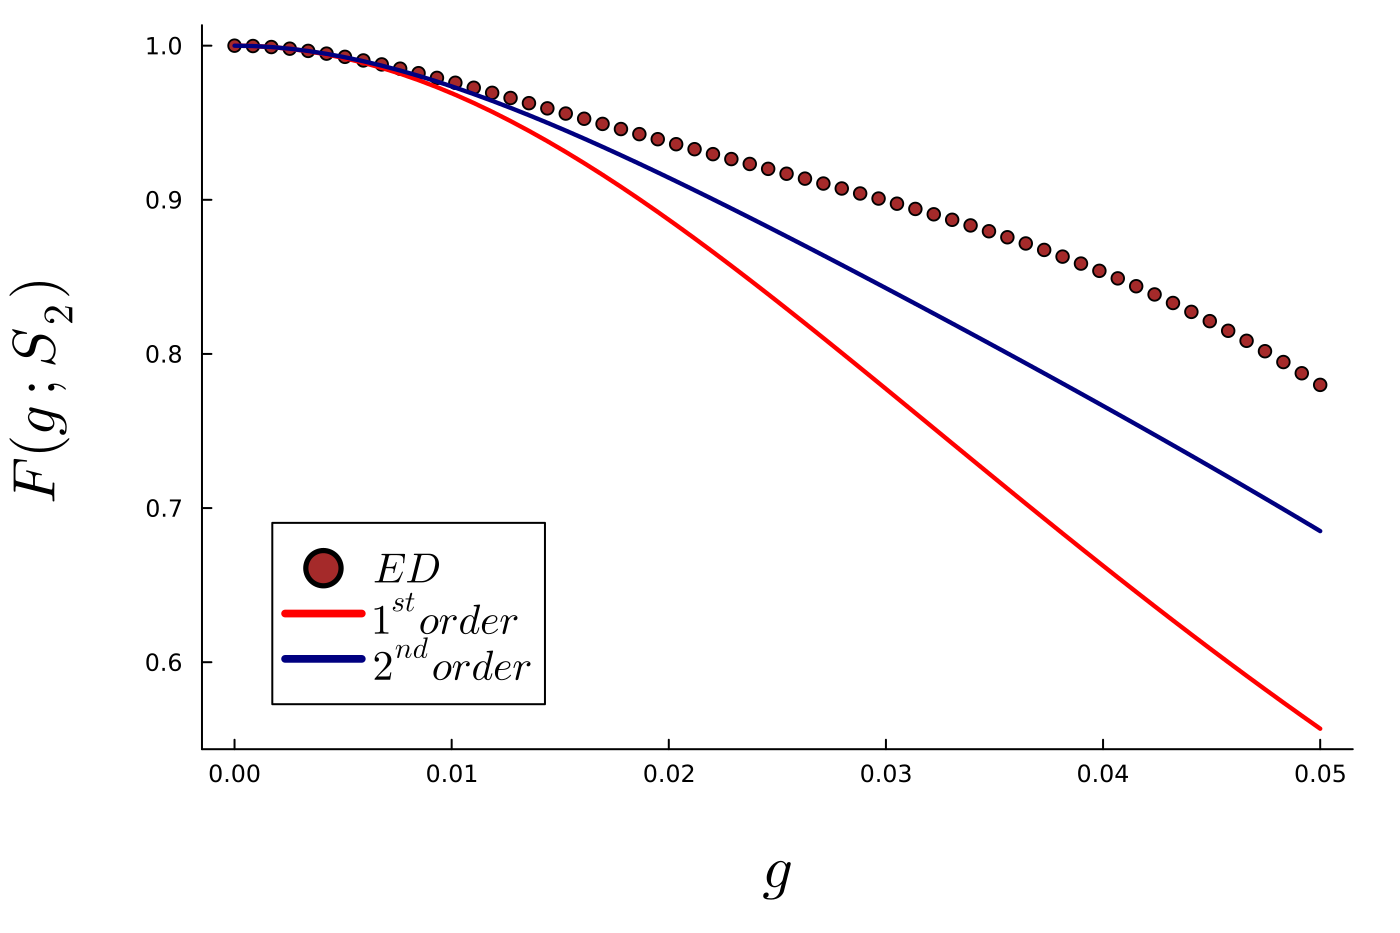

In [27]:
using Plots
using LaTeXStrings
using Plots.PlotMeasures
gr()

plot_size = (700,466.67)

p = scatter(J2_list,J2_ED_overlap_list,marker=:circle,markersize=3.5,markercolor=:brown,markerstrokecolor=:black,
         markerstrokewidth=1,label="\$ED\$",size=plot_size,dpi=200)

plot!(J2_list,J2_pert_1st_overlap_list,lw=2.2,c=:red,label="\$1^{st} order\$")
plot!(J2_list,J2_pert_2nd_overlap_list,lw=2.2,c=:navy,label="\$2^{nd} order\$")

plot!(left_margin=4.5mm,right_margin=4mm,top_margin=1.2mm,bottom_margin=5mm)
plot!(framestyle=:axis)
plot!(grid=false,gridlinewidth=0.6,gridalpha=0.2,gridcolor=:gray)
plot!(legend_position=(0.15,0.25),legendfontsize=14,legend_background_color=:white,
    legend_foreground_color=:black,legend_columns=1)
# plot!(ylims=(-3.45,-3.35))

xlabel!("\n\$g\$",guidefontsize=20)
ylabel!("\$F(g\\ ;S_{$n})\$\n",guidefontsize=20)
title_text = "\$ N = $N \\quad $boundary,\\ J_{1} = $(round(J1,digits=6)),\\ J_{3} = $(round(J3,digits=6)), \\ D = $(round(D,digits=6)), \\ h = $(round(h,digits=6)) \$"
# title!(title_text,titlefontsize=16)

x1,x_step,x2 = 0.00,0.01,0.05
y1,y_step,y2 = 0.8,0.05,1.0
# y1,y_step,y2 = 0.6,0.1,1.0
xticks = (x1:x_step:x2,[@sprintf("%.2f",x) for x in x1:x_step:x2])
yticks = (y1:y_step:y2,[@sprintf("%.2f",y) for y in y1:y_step:y2])
xminor_ticks = 2
yminor_ticks = 2
# plot!(xticks=xticks,yticks=yticks,xminorgrid=false,yminorgrid=false,
#       xminorticks=xminor_ticks, yminorticks=yminor_ticks,tickfontsize=15,tick_direction=:out)
# plot!(ylims=(-4.5,-2.5))

folder_name = "D:\\IACS_Project\\spin-1_XY\\plots\\1D\\spin-1_XY_N=$(N)\\sec_nbr_perturbed\\$(boundary)\\perturbative_wave_function"
if !isdir(folder_name)
    mkpath(folder_name)
end

J2 = round(J2_list[end],digits=6)
file_path = joinpath(folder_name,"Perturbative_fidelity_Sn=$(n)_J2max=$(J2)_J1=$(round(J1,digits=6))_J3=$(round(J3,digits=6))_D=$(round(D,digits=6))_h=$(round(h,digits=6)).png")

display(p)
# savefig(p,file_path)

### 3) Perturbation matrix element vs energy difference

In [ ]:
N = 10
J1,J3,D,h = 1.0,0.1,0.1,1.0
boundary = "OBC"
use_sparse = false
n::Int64 = 2
mz::Int64 = 2*n-N

@time begin
    nearest_bond_list = gen_bonds_1D(N,boundary)
    third_nbr_bond_list = gen_3rd_nbr_bonds_1D(N,boundary)
    basis_list = gen_basis_mz_1D(N,mz)
    println(length(basis_list))
    basis_new1 = similar(basis_list[1])
    basis_new2 = similar(basis_list[1])
    scar_state::Vector{Float64} = scar_state_1D(N,n,basis_list)
    scar_energy::Float64 = mz*h+N*D
    H_XY,H_size = Ham_XY_1D(J1,J3,D,h,N,basis_list,basis_new1,basis_new2,nearest_bond_list,
                            third_nbr_bond_list,use_sparse)  
end;

In [ ]:
@time XY_energy,XY_eigenvector = eigen(H_XY);

In [ ]:
sec_nbr_bond_list = gen_2nd_nbr_bonds_1D(N,boundary)
basis_new = similar(basis_list[1])
H_sec_nbr,H_size = Ham_2nd_nbr_1D(N,basis_list,basis_new,sec_nbr_bond_list,use_sparse);

In [ ]:
scar_eigenspec_overlap_list::Vector{Float64} = Vector{Float64}(undef,H_size)

@time begin
    for (i,E) in enumerate(XY_energy)
        scar_eigenspec_overlap_list[i] = abs2(dot(XY_eigenvector[:,i],scar_state))      
    end
end;
max_overlap,max_index = findmax(scar_eigenspec_overlap_list)

In [ ]:
scar_energy,XY_energy[max_index+1]

In [ ]:
energy_diff_list::Vector{Float64} = Vector{Float64}(undef,H_size-1)
pert_matrix_element_list::Vector{Float64} = Vector{Float64}(undef,H_size-1)
outvect::Vector{Float64} = Vector{Float64}(undef,H_size)

@time begin
    j::Int64 = 1
    for (i::Int64,E::Float64) in enumerate(XY_energy)
        if i != max_index
            energy_diff_list[j] = E-scar_energy
            mul!(outvect,H_sec_nbr,scar_state)
            pert_matrix_element_list[j] = abs(dot(XY_eigenvector[:,i],outvect))
            j += 1
        end
    end
end;

In [ ]:
using Plots
using LaTeXStrings
using Plots.PlotMeasures
gr()

plot_size = (700,466.67)

p = plot(energy_diff_list,pert_matrix_element_list./abs.(energy_diff_list),marker=:circle,markersize=2,markercolor=:navy,markerstrokecolor=:black,
         markerstrokewidth=0,lw=0,size=plot_size,dpi=200)

plot!(left_margin=4mm,right_margin=1.2mm,top_margin=1.2mm,bottom_margin=5mm)
plot!(framestyle=:axis)
plot!(grid=false,gridlinewidth=0.6,gridalpha=0.2,gridcolor=:gray)
plot!(legend_position=(0.15,0.9),legendfontsize=14,legend_background_color=:white,
    legend_foreground_color=:black,legend_columns=1,legend=false)
# plot!(ylims=(-3.45,-3.35))

xlabel!("\n\$E^{(0)}_n-E^{(0)}_{S_{$n}}\$",guidefontsize=20)
ylabel!("\$|\\langle n^{(0)}|H_p|S_{$n}\\rangle|\$",guidefontsize=20)
title_text = "\$ N = $N \\quad $boundary,\\ J_{1} = $(round(J1,digits=6)),\\ J_{3} = $(round(J3,digits=6)), \\ D = $(round(D,digits=6)), \\ h = $(round(h,digits=6)) \$"
# title!(title_text,titlefontsize=16)

x1,x_step,x2 = 0.00,0.01,0.05
y1,y_step,y2 = 0.6,0.0025,0.61
xticks = (x1:x_step:x2,[@sprintf("%.2f",x) for x in x1:x_step:x2])
yticks = (y1:y_step:y2,[@sprintf("%.4f",y) for y in y1:y_step:y2])
xminor_ticks = 4
yminor_ticks = 2
# plot!(xticks=xticks,yticks=yticks,xminorgrid=false,yminorgrid=false,
#       xminorticks=xminor_ticks, yminorticks=yminor_ticks,tickfontsize=15,tick_direction=:out)
# plot!(xlims=(-0.1,0.1))

folder_name = "D:\\IACS_Project\\spin-1_XY\\plots\\1D\\spin-1_XY_N=$(N)\\sec_nbr_perturbed\\$(boundary)\\perturbative_corrections"
if !isdir(folder_name)
    mkpath(folder_name)
end

file_path = joinpath(folder_name,"Perturbative_energy_Sn=$(n)_J1=$(round(J1,digits=6))_J3=$(round(J3,digits=6))_D=$(round(D,digits=6))_h=$(round(h,digits=6)).png")

display(p)
# savefig(p,file_path)